In [ ]:
# Import PyTorch
import torch
from torch import nn
from tqdm.auto import tqdm

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install torchinfo
    from torchinfo import summary

# Download helper functions from Learn PyTorch repo (if not already downloaded)
import requests
print("Downloading helper_functions.py")
# Note: you need the "raw" GitHub URL for this to work
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)

from helper_functions import accuracy_fn


# Import matplotlib for visualization
import matplotlib.pyplot as plt

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int
):
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=1
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=1
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("/content/drive/MyDrive/Colab Notebooks/")

image_path = data_path/"pizza_steak_sushi (1)"

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Colab Notebooks/pizza_steak_sushi (1)/train'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/pizza_steak_sushi (1)/test'))

In [ ]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                        test_dir=test_dir,
                                                                        transform=auto_transforms,
                                                                        batch_size= 32)

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

#efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model = efficientnet_b0(weights="DEFAULT")

# Old weights with accuracy 76.130%
weights=EfficientNet_B0_Weights.DEFAULT

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
       input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
       # col_names=["input_size"], # uncomment for smaller output
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
model.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)


# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)


# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
   torch.nn.Dropout(p=0.2, inplace=True),
   torch.nn.Linear(in_features=1280,
                   out_features=output_shape, # same number of output units as our number of classes
                   bias=True))

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn):
   train_loss, train_acc = 0, 0

   for batch, (X, y) in enumerate(data_loader):
       # 1. Forward pass
       y_pred = model(X)


       # 2. Calculate loss
       loss = loss_fn(y_pred, y)
       train_loss += loss
       train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels


       # 3. Optimizer zero grad
       optimizer.zero_grad()


       # 4. Loss backward
       loss.backward()


       # 5. Optimizer step
       optimizer.step()


   # Calculate loss and accuracy per epoch and print out what's happening
   train_loss /= len(data_loader)
   train_acc /= len(data_loader)
   print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
             model: torch.nn.Module,
             loss_fn: torch.nn.Module,
             accuracy_fn):
   test_loss, test_acc = 0, 0
   model.eval() # put model in eval mode
   # Turn on inference context manager
   with torch.inference_mode():
       for X, y in data_loader:

           # 1. Forward pass
           test_pred = model(X)

           # 2. Calculate loss and accuracy
           test_loss += loss_fn(test_pred, y)
           test_acc += accuracy_fn(y_true=y,
               y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
           )

       # Adjust metrics and print out
       test_loss /= len(data_loader)
       test_acc /= len(data_loader)
       print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
   loss, acc = 0, 0
   model.eval()
   with torch.inference_mode():
       for X, y in data_loader:
           y_pred = model(X)
           loss += loss_fn(y_pred, y)
           acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

       # Scale loss and acc
       loss /= len(data_loader)
       acc /= len(data_loader)
   return {"model_name": model.__class__.__name__, # only works when model was created with a class
           "model_loss": loss.item(),
           "model_acc": acc}

In [ ]:
eval_model(model=model,
              data_loader= test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

{'model_name': 'EfficientNet',
 'model_loss': 0.2774806320667267,
 'model_acc': 89.58333333333333}

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer) -> Tuple[float, float]:
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module) -> Tuple[float, float]:
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int) -> Dict[str, List]:
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1723 | train_acc: 0.9727 | test_loss: 0.2654 | test_acc: 0.8958
Epoch: 2 | train_loss: 0.2828 | train_acc: 0.8594 | test_loss: 0.1641 | test_acc: 0.9792
Epoch: 3 | train_loss: 0.1201 | train_acc: 1.0000 | test_loss: 0.1040 | test_acc: 0.9792
Epoch: 4 | train_loss: 0.1933 | train_acc: 0.8750 | test_loss: 0.1118 | test_acc: 0.9792
Epoch: 5 | train_loss: 0.1101 | train_acc: 0.8750 | test_loss: 0.1152 | test_acc: 0.9688
[INFO] Total training time: 394.806 seconds


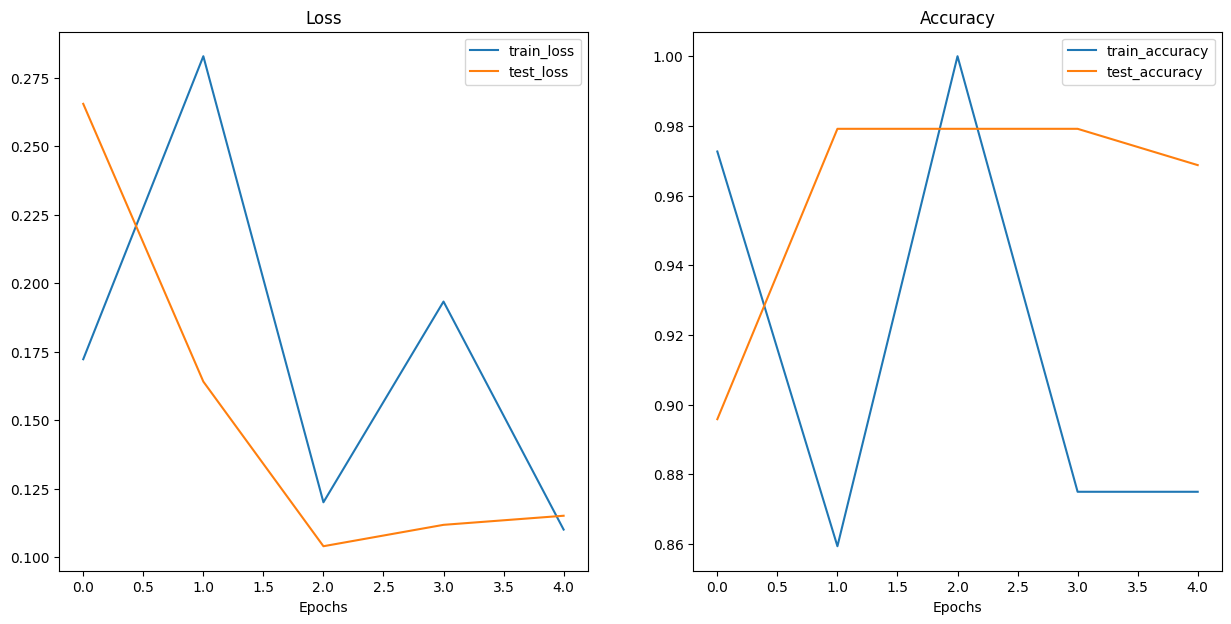

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [ ]:
save_model(model=model,
               target_dir="/content/drive/MyDrive/Colab Notebooks",
               model_name= 'transfer_learning_efficient_bo.pth')

[INFO] Saving model to: /content/drive/MyDrive/Colab Notebooks/transfer_learning_efficient_bo.pth
